In [ ]:
import cv2
import numpy as np
import os

# Directories
image_dir = "/content/images"
txt_dir = "/content/txt"
mask_dir = "/content/masks"

# Ensure mask directory exists
os.makedirs(mask_dir, exist_ok=True)

image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]  # <-- Change here

for img_name in image_filenames:
    img_path = os.path.join(image_dir, img_name)
    txt_path = os.path.join(txt_dir, img_name.replace(".jpg", ".txt"))  # <-- Change here
    mask_path = os.path.join(mask_dir, img_name.replace(".jpg", ".png"))  # Save masks as PNG

    image = cv2.imread(img_path)
    if image is None:
        print(f"❌ ERROR: Could not read {img_path}")
        continue

    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    if os.path.exists(txt_path):
        with open(txt_path, "r") as file:
            for line in file:
                values = line.split()
                if len(values) != 5:
                    print(f"⚠️ Skipping invalid annotation in {txt_path}: {line.strip()}")
                    continue

                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                x1 = int((x_center - bbox_width / 2) * width)
                y1 = int((y_center - bbox_height / 2) * height)
                x2 = int((x_center + bbox_width / 2) * width)
                y2 = int((y_center + bbox_height / 2) * height)

                x1, y1, x2, y2 = max(0, x1), max(0, y1), min(width - 1, x2), min(height - 1, y2)

                print(f"📌 Drawing box on {img_name}: ({x1}, {y1}) -> ({x2}, {y2})")

                cv2.rectangle(mask, (x1, y1), (x2, y2), 255, -1)

        cv2.imwrite(mask_path, mask)
        print(f"✅ Mask saved: {mask_path}")

    else:
        print(f"⚠️ No annotation file for {img_name}")


📌 Drawing box on cocklebur_002.jpg: (0, 61) -> (301, 254)
📌 Drawing box on cocklebur_002.jpg: (212, 390) -> (1056, 827)
📌 Drawing box on cocklebur_002.jpg: (505, 47) -> (664, 372)
✅ Mask saved: /content/masks/cocklebur_002.png
📌 Drawing box on cocklebur_017.jpg: (1694, 1140) -> (2294, 1726)
📌 Drawing box on cocklebur_017.jpg: (2178, 669) -> (2750, 1354)
📌 Drawing box on cocklebur_017.jpg: (1664, 582) -> (2278, 1211)
✅ Mask saved: /content/masks/cocklebur_017.png
📌 Drawing box on cocklebur_009.jpg: (299, 242) -> (821, 786)
📌 Drawing box on cocklebur_009.jpg: (581, 833) -> (885, 890)
📌 Drawing box on cocklebur_009.jpg: (555, 25) -> (756, 238)
✅ Mask saved: /content/masks/cocklebur_009.png
📌 Drawing box on cocklebur_015.jpg: (1880, 761) -> (2494, 1261)
📌 Drawing box on cocklebur_015.jpg: (1779, 1512) -> (2222, 1912)
📌 Drawing box on cocklebur_015.jpg: (2094, 1183) -> (2765, 1796)
✅ Mask saved: /content/masks/cocklebur_015.png
📌 Drawing box on cocklebur_018.jpg: (2065, 1011) -> (2694, 1683

In [ ]:
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the dataset class
class AgricultureSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get file paths
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", ".png"))

        # Read images and masks
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        # Apply transformations if specified (using albumentations)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert mask to tensor (LongTensor for segmentation)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

# Define Albumentations transformations for image and mask
transform = A.Compose([
    A.Resize(256, 256),                      # Resize both image and mask
    A.RandomCrop(width=256, height=256),     # Randomly crop the image
    A.HorizontalFlip(p=0.5),                 # Augment with random horizontal flip
    A.RandomRotate90(p=0.5),                 # Randomly rotate image and mask
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    ToTensorV2(),                            # Convert image to tensor
])

# Define data directories
image_dir = "/content/images"
mask_dir = "/content/masks"

# Create dataset and dataloaders
dataset = AgricultureSegmentationDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check the dataset and dataloader
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
    break  # Just check the first batch


<ipython-input-2-817f63113be4>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Image batch shape: torch.Size([4, 3, 256, 256]), Mask batch shape: torch.Size([4, 256, 256])


In [ ]:
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Define the dataset class
class AgricultureSegmentationDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Get file paths
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx].replace(".jpg", ".png"))

        # Read images and masks
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale

        # Normalize mask (ensure it has values between 0 and num_classes-1)
        mask = mask.astype(np.uint8)  # Convert to uint8
        mask[mask > 3] = 3  # Assume 4 disease classes (0-3), limit values to this range

        # Apply transformations if specified (using albumentations)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Fix: Ensure mask is a tensor
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask

# Define Albumentations transformations for image and mask
transform = A.Compose([
    A.Resize(256, 256),                      # Resize both image and mask
    A.RandomCrop(width=256, height=256),     # Randomly crop the image
    A.HorizontalFlip(p=0.5),                 # Augment with random horizontal flip
    A.RandomRotate90(p=0.5),                 # Randomly rotate image and mask
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    ToTensorV2(),                            # Convert image to tensor
])

# Define data directories
image_dir = "/content/images"
mask_dir = "/content/masks"

# List all image files
all_image_filenames = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Split into training and testing (80% train, 20% test)
train_files, test_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)

# Create dataset and dataloaders
train_dataset = AgricultureSegmentationDataset(train_files, image_dir, mask_dir, transform=transform)
test_dataset = AgricultureSegmentationDataset(test_files, image_dir, mask_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Check the dataset and dataloader
for images, masks in train_loader:
    print(f"Train Batch - Image shape: {images.shape}, Mask shape: {masks.shape}")
    break  # Just check the first batch

for images, masks in test_loader:
    print(f"Test Batch - Image shape: {images.shape}, Mask shape: {masks.shape}")
    break  # Just check the first batch


Train Batch - Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 256, 256])
Test Batch - Image shape: torch.Size([4, 3, 256, 256]), Mask shape: torch.Size([4, 256, 256])


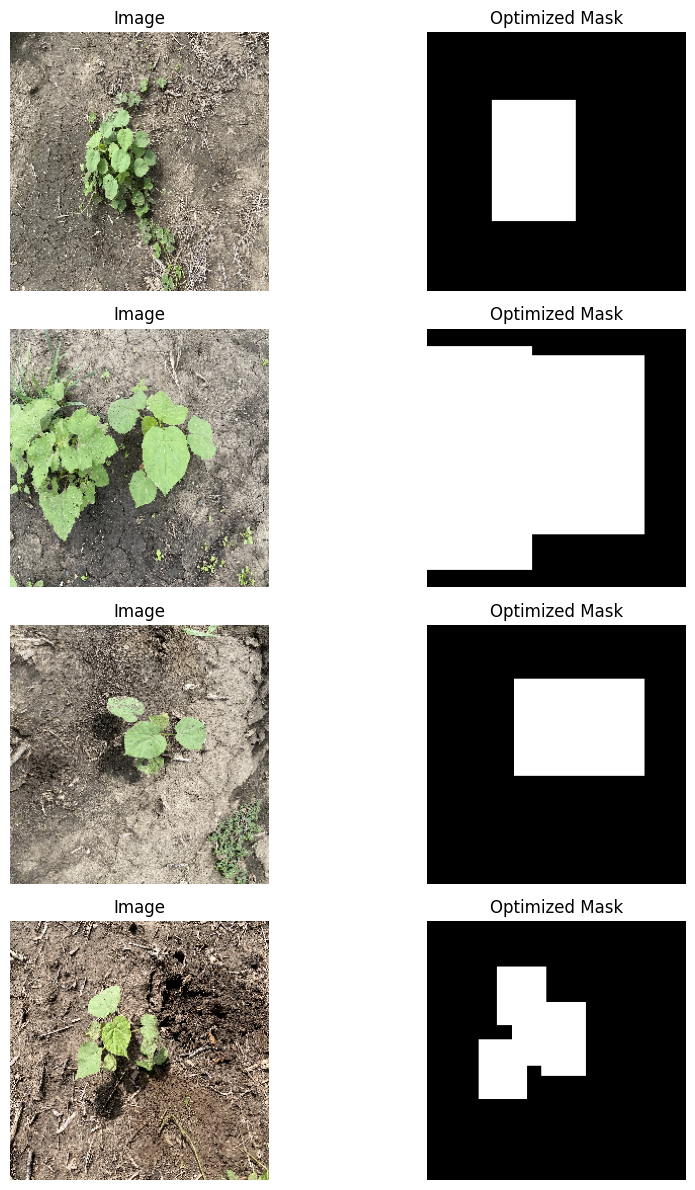

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to check mask values and ensure correct formatting
def optimize_masks(masks):
    # Convert masks to binary (assuming single-channel segmentation)
    masks = masks.float()  # Convert to float if not already
    masks = (masks > 0).long()  # Convert to binary format (0 and 1)

    return masks

# Check and visualize the optimized masks
def visualize_masks(dataloader, num_samples=4):
    images, masks = next(iter(dataloader))
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert tensor to numpy for plotting
    masks = optimize_masks(masks.cpu())  # Optimize masks

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i], cmap="gray")
        axes[i, 1].set_title("Optimized Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Run optimization and display results
visualize_masks(train_loader)


In [ ]:
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models

class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and mask
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Check if image and mask are loaded correctly
        if image is None or mask is None:
            raise ValueError(f"Error loading image or mask for index {idx}")

        # Ensure the same shape for image and mask
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        # Convert mask to long tensor (required for cross-entropy loss)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

# Define transformations with Resize to ensure image and mask have same size
transform = A.Compose([
    A.Resize(256, 256),  # Resize both image and mask to the same size
    A.RandomCrop(width=256, height=256),  # Apply random cropping if needed
    A.RandomRotate90(p=0.5),  # Randomly rotate images and masks
    A.HorizontalFlip(p=0.5),  # Flip images and masks horizontally
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize image
    ToTensorV2()  # Convert image to tensor
], additional_targets={'mask': 'mask'}, is_check_shapes=False)  # Disable shape check

# Dataset paths
images_dir = '/content/images'
masks_dir = '/content/masks'

# Create dataset and dataloader
dataset = CustomDataset(images_dir, masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check the dataset and dataloader
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
    break  # Just check the first batch


<ipython-input-5-77d1e01ca6a9>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Image batch shape: torch.Size([4, 3, 256, 256]), Mask batch shape: torch.Size([4, 256, 256])


In [ ]:
import os
import cv2
import torch
import random
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------------------- Configuration ----------------------------
image_dir = '/content/images'  # Change as needed
mask_dir = '/content/masks'    # Change as needed
image_size = 256
batch_size = 4
epochs = 6
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------- Dataset Class ----------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = T.ToTensor()(image)
            mask = torch.tensor(mask, dtype=torch.float32)

        mask = (mask > 127).float()  # Binarize
        return image, mask

# ------------------------ Transforms ------------------------
train_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize(),
    ToTensorV2(),
])

# -------------------- Load and Split Dataset --------------------
full_dataset = SegmentationDataset(image_dir, mask_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply correct transforms to validation split
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# -------------------- U-Net++ Model --------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class NestedUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        nb_filter = [64, 128, 256, 512, 1024]

        self.pool = nn.MaxPool2d(2, 2)
        self.up = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = ConvBlock(in_channels, nb_filter[0])
        self.conv1_0 = ConvBlock(nb_filter[0], nb_filter[1])
        self.conv2_0 = ConvBlock(nb_filter[1], nb_filter[2])
        self.conv3_0 = ConvBlock(nb_filter[2], nb_filter[3])
        self.conv4_0 = ConvBlock(nb_filter[3], nb_filter[4])

        self.conv0_1 = ConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0])
        self.conv1_1 = ConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.conv2_1 = ConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv3_1 = ConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3])

        self.conv0_2 = ConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0])
        self.conv1_2 = ConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1])
        self.conv2_2 = ConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2])

        self.conv0_3 = ConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0])
        self.conv1_3 = ConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1])

        self.conv0_4 = ConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))

        return self.final(x0_4)

# -------------------- Metrics --------------------
def pixel_accuracy(preds, masks):
    preds = (preds > 0.5).float()
    correct = (preds == masks).float()
    return correct.mean().item()

def iou_score(preds, masks):
    preds = (preds > 0.5).float()
    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    return (intersection / (union + 1e-7)).item()

def dice_score(preds, masks):
    preds = (preds > 0.5).float()
    intersection = (preds * masks).sum()
    return (2. * intersection / (preds.sum() + masks.sum() + 1e-7)).item()

# -------------------- Training Function --------------------
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': [],
               'iou': [], 'val_iou': [], 'dice': [], 'val_dice': []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_iou, train_dice = 0, 0, 0, 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, masks = images.to(device), masks.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            preds = torch.sigmoid(outputs)
            train_loss += loss.item()
            train_acc += pixel_accuracy(preds, masks)
            train_iou += iou_score(preds, masks)
            train_dice += dice_score(preds, masks)

        model.eval()
        val_loss, val_acc, val_iou, val_dice = 0, 0, 0, 0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                images, masks = images.to(device), masks.to(device).unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, masks)
                preds = torch.sigmoid(outputs)

                val_loss += loss.item()
                val_acc += pixel_accuracy(preds, masks)
                val_iou += iou_score(preds, masks)
                val_dice += dice_score(preds, masks)

        # Store metrics
        n_train = len(train_loader)
        n_val = len(val_loader)
        history['loss'].append(train_loss / n_train)
        history['acc'].append(train_acc / n_train)
        history['iou'].append(train_iou / n_train)
        history['dice'].append(train_dice / n_train)
        history['val_loss'].append(val_loss / n_val)
        history['val_acc'].append(val_acc / n_val)
        history['val_iou'].append(val_iou / n_val)
        history['val_dice'].append(val_dice / n_val)

        print(f"Epoch {epoch+1}: Train Loss={train_loss/n_train:.4f}, Val Loss={val_loss/n_val:.4f}, "
              f"IoU={val_iou/n_val:.4f}, Dice={val_dice/n_val:.4f}")

    return model, history

# -------------------- Train --------------------
model = NestedUNet()
model, history = train_model(model, train_loader, val_loader, epochs=epochs, lr=lr)


Epoch 1/6 - Validation: 100%|██████████| 8/8 [03:13<00:00, 24.24s/it]


Epoch 1: Train Loss=0.4377, Val Loss=0.6982, IoU=0.4464, Dice=0.6124


Epoch 2/6 - Validation: 100%|██████████| 8/8 [03:10<00:00, 23.84s/it]


Epoch 2: Train Loss=0.3095, Val Loss=0.3551, IoU=0.5523, Dice=0.7064


Epoch 3/6 - Validation: 100%|██████████| 8/8 [03:14<00:00, 24.25s/it]


Epoch 3: Train Loss=0.2695, Val Loss=0.2788, IoU=0.5923, Dice=0.7413


Epoch 4/6 - Validation: 100%|██████████| 8/8 [03:07<00:00, 23.46s/it]


Epoch 4: Train Loss=0.2560, Val Loss=0.2301, IoU=0.6333, Dice=0.7714


Epoch 5/6 - Validation: 100%|██████████| 8/8 [03:14<00:00, 24.29s/it]


Epoch 5: Train Loss=0.2416, Val Loss=0.2134, IoU=0.5712, Dice=0.7217


Epoch 6/6 - Validation: 100%|██████████| 8/8 [03:11<00:00, 23.88s/it]

Epoch 6: Train Loss=0.2305, Val Loss=0.2531, IoU=0.6116, Dice=0.7537


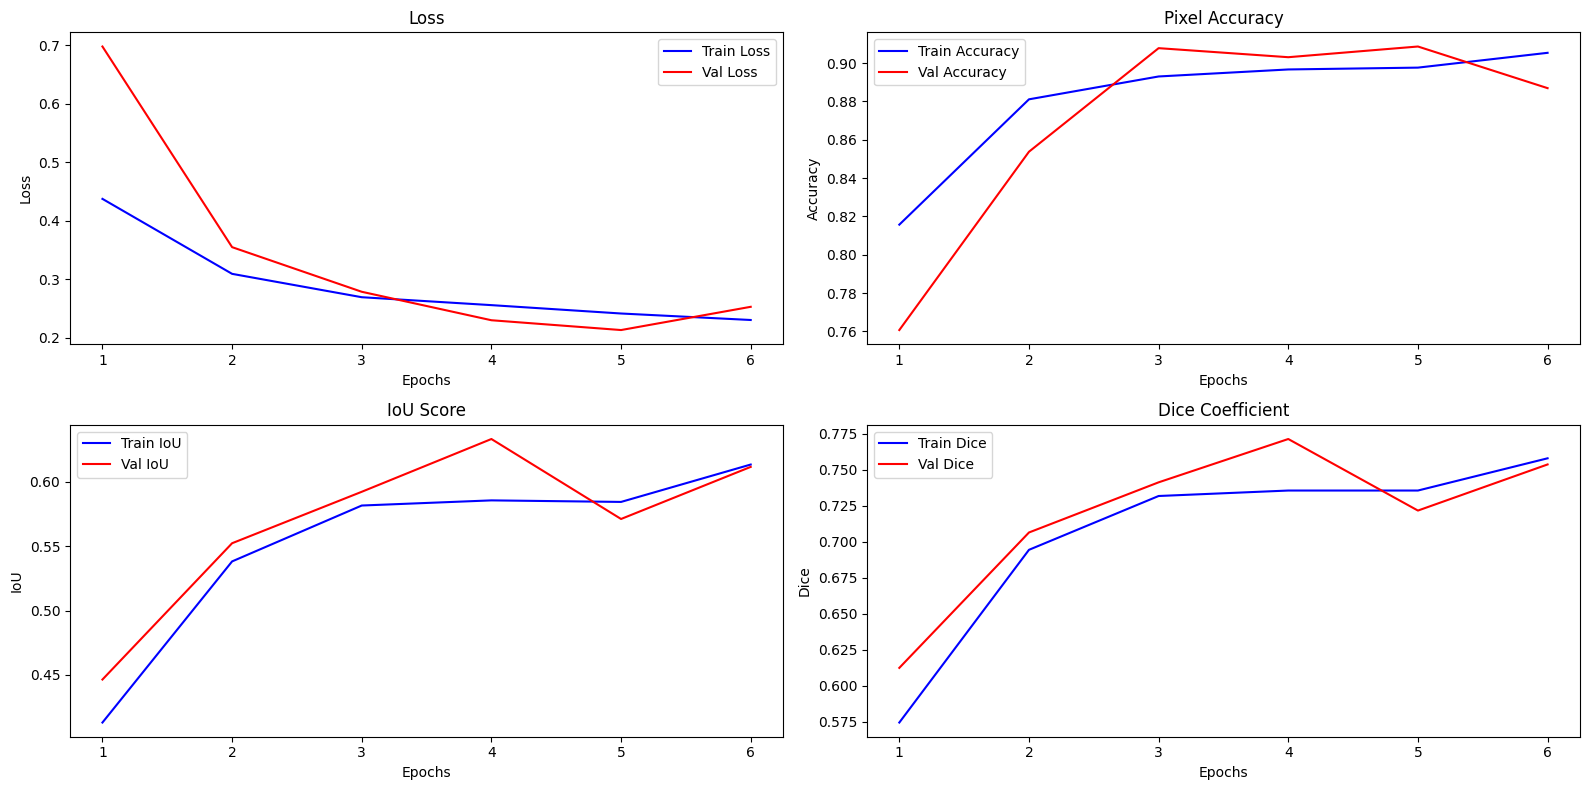

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history['loss']) + 1)

    plt.figure(figsize=(16, 8))

    # Plot Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['acc'], 'b-', label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy')
    plt.title('Pixel Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot IoU
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['iou'], 'b-', label='Train IoU')
    plt.plot(epochs, history['val_iou'], 'r-', label='Val IoU')
    plt.title('IoU Score')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Plot Dice
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['dice'], 'b-', label='Train Dice')
    plt.plot(epochs, history['val_dice'], 'r-', label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use this to plot the training history
plot_metrics(history)


In [ ]:
import torch

# Prepare a dictionary with the model state and metrics
model_save_data = {
    'model_state_dict': model.state_dict(),
    'metrics': {
        'train_loss': history['loss'],
        'val_loss': history['val_loss'],
        'train_acc': history['acc'],
        'val_acc': history['val_acc'],
        'train_iou': history['iou'],
        'val_iou': history['val_iou'],
        'train_dice': history['dice'],
        'val_dice': history['val_dice']
    }
}

# Specify the model save path in the current Colab environment
model_save_path = '/content/unet_plus_trained_model_with_metrics.pth'

# Save the model state and metrics
torch.save(model_save_data, model_save_path)
print(f"U-Net++ model with metrics saved successfully to {model_save_path}")

# Download the saved model to your local machine
from google.colab import files
files.download(model_save_path)


U-Net++ model with metrics saved successfully to /content/unet_plus_trained_model_with_metrics.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

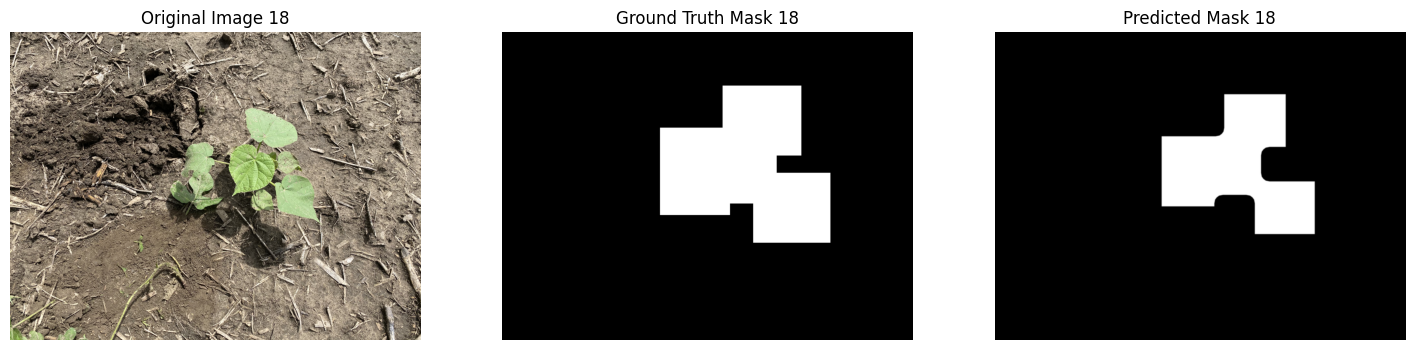

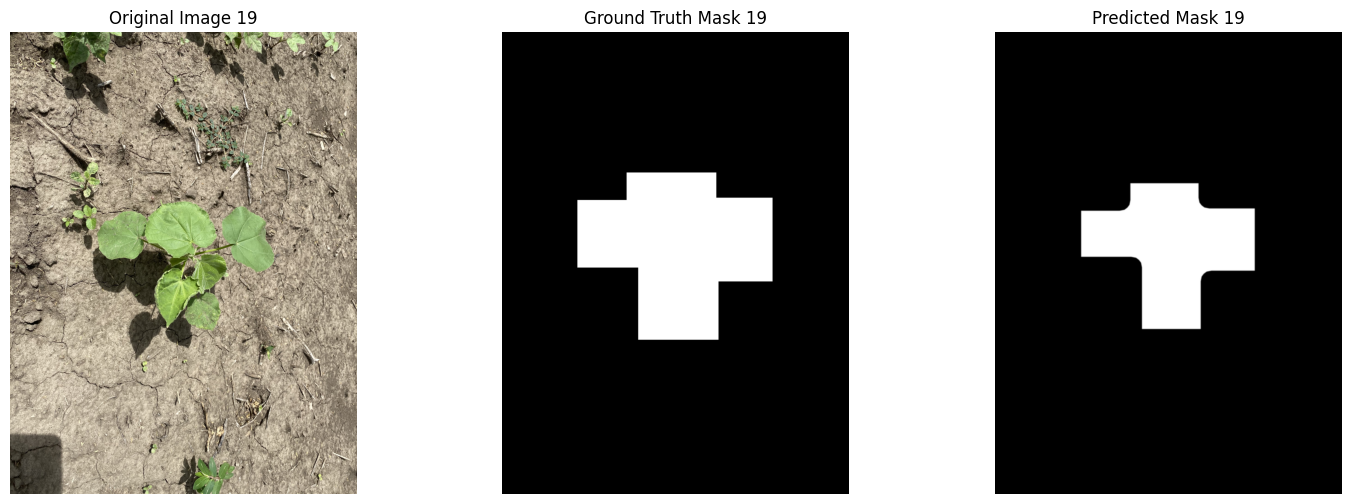

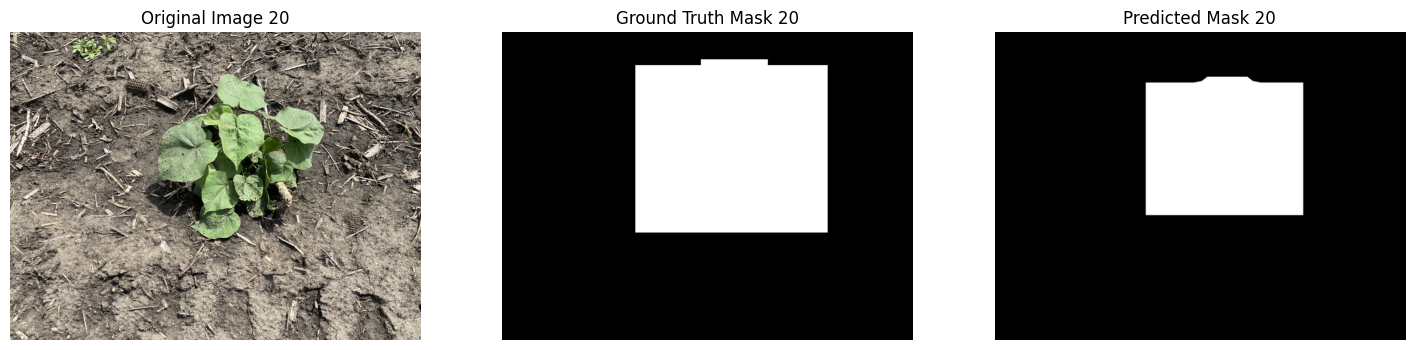

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from sklearn.metrics import jaccard_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNetPlusPlus, self).__init__()
        self.encoder1 = ConvBlock(in_channels, features[0])
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = ConvBlock(features[0], features[1])
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = ConvBlock(features[1], features[2])
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = ConvBlock(features[2], features[3])
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(features[3], features[3]*2)

        self.up4 = nn.ConvTranspose2d(features[3]*2, features[3], 2, stride=2)
        self.decoder4 = ConvBlock(features[3]*2, features[3])

        self.up3 = nn.ConvTranspose2d(features[3], features[2], 2, stride=2)
        self.decoder3 = ConvBlock(features[2]*2, features[2])

        self.up2 = nn.ConvTranspose2d(features[2], features[1], 2, stride=2)
        self.decoder2 = ConvBlock(features[1]*2, features[1])

        self.up1 = nn.ConvTranspose2d(features[1], features[0], 2, stride=2)
        self.decoder1 = ConvBlock(features[0]*2, features[0])

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.up4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))

        dec3 = self.up3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))

        dec2 = self.up2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))

        dec1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)


class PlantDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith(".png") or f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])  # Assuming same filename

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0).float()

        return image, mask

def get_test_loader(image_dir, mask_dir, batch_size=4, img_size=256):
    transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2(),
    ])
    dataset = PlantDataset(image_dir, mask_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)


def load_model(model, checkpoint_path, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model


def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    return (
        jaccard_score(y_true, y_pred, average='binary'),
        f1_score(y_true, y_pred, average='binary'),
        accuracy_score(y_true, y_pred)
    )


def test_model(model, dataloader, device):
    ious, dices, accs = [], [], []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                iou, dice, acc = calculate_metrics(
                    masks[i].cpu().numpy(), preds[i].cpu().numpy()
                )
                ious.append(iou)
                dices.append(dice)
                accs.append(acc)

    print("\n--- Test Results ---")
    print(f"IoU:  {np.mean(ious):.4f}")
    print(f"Dice: {np.mean(dices):.4f}")
    print(f"Acc:  {np.mean(accs):.4f}")

    return np.mean(ious), np.mean(dices), np.mean(accs)


def visualize_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    count = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                img = images[i].permute(1, 2, 0).cpu().numpy()
                mask = masks[i][0].cpu().numpy()
                pred = preds[i][0].cpu().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(img)
                axs[0].set_title("Image")
                axs[1].imshow(mask, cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred, cmap='gray')
                axs[2].set_title("Prediction")
                plt.show()

                count += 1
                if count >= num_samples:
                    return

# ----------- Main Test Runner -----------
if __name__ == "__main__":
    # Paths
    test_image_dir = "/content/images"
    test_mask_dir = "/content/labels"
    model_checkpoint = "/content/unetpp_model.pth"

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNetPlusPlus(in_channels=3, out_channels=1)
    model = load_model(model, model_checkpoint, device)

    test_loader = get_test_loader(test_image_dir, test_mask_dir, batch_size=4)

    # Test
    test_model(model, test_loader, device)

    # Visualize
    visualize_predictions(model, test_loader, device, num_samples=5)
